In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

#from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import KFold, train_test_split, cross_val_score 

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

# Regresión regularizada

## Objetivos

Al final del día deberías poder

  * Indicar el propósito de la regresión de Lasso y Ridge y definir su función de pérdida
  * Elije el hiperparámetro de regularización con validación cruzada
  * Interpreta los resultados de la regresión de Lasso y Ridge.

## Revisión: regresión lineal y aprendizaje automático

1. ¿Cuál es la relación supuesta entre características y objetivos en un modelo de regresión lineal?
2. ¿Qué es la validación cruzada?
3. ¿Qué es una función de pérdida? ¿Cuál es la función de pérdida para la regresión lineal?
4. ¿Cuál es el equilibrio entre sesgo y varianza en el aprendizaje automático?
5. ¿Podemos sobreajustar con la regresión lineal?


<br><br><br><br>
**Tres temas que seguirán apareciendo en los nuevos métodos de aprendizaje automático son:**

1. Funciones de costo/pérdida/objetivo: RSS para regresión lineal

<!-- ![](costo.png) -->

2. Forma funcional supuesta de un modelo: $\hat{y}=\beta_0 + \beta_1 x_{1} + \beta_2 x_{2} + \beta_3 x_{3}+ ...$
3. Tratar con la compensación de la varianza del sesgo

### ¿Qué cubriremos en esta conferencia?

Nos ocuparemos de los modelos de regresión lineal de alta varianza cambiando la función de pérdida. Este proceso se conoce como **regularización.**

### Intercambio de sesgo-varianza con regresión lineal

Para comenzar, creemos un modelo con regresión lineal para ajustar nuestros datos. Para hacer esto, intentaré ajustar un modelo a los datos usando varios grados de transformación polinomial (polinomios de 1, 3 y hasta 30 grados).

Sin embargo, los datos se generarán a través del siguiente proceso:

$$f(x) = x^{3} - 2 x^{2} + ruido$$

In [ ]:
# crear datos -- polinomio
x_ex1 = np.linspace(-2,3,100)
y_ex1 = (x_ex1**3) - 2*(x_ex1**2) + 2*np.random.normal(size=len(x_ex1))

# crear datos de prueba también...
x_ex1_test = np.random.uniform(-2,3,100)
y_ex1_test = (x_ex1_test**3) -2*(x_ex1_test**2) + 2*np.random.normal(size=len(x_ex1_test))

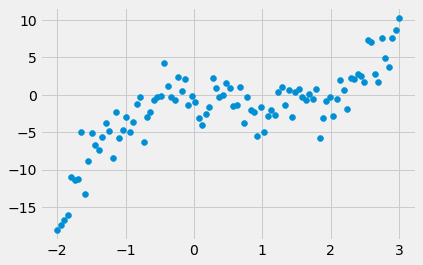

In [ ]:
# Graficar datos
fig,ax = plt.subplots()
ax.scatter(x_ex1,y_ex1);

Construye tres modelos donde las características sean transformaciones polinómicas hasta el grado n de x:

$$f(x)=\beta_0 + \beta_1 x + \beta_2 x^{2} + \beta_3 x^{3} + ... + \beta_3 x^{n}$$

In [ ]:
# Construye tres modelos de diferentes grados de polinomios

# Característica útil en sklearn que creará automáticamente datos polinómicos 
x3 = PolynomialFeatures(3).fit_transform(x_ex1.reshape(len(x_ex1),-1))[:,1:]
x30 = PolynomialFeatures(30).fit_transform(x_ex1.reshape(len(x_ex1),-1))[:,1:]
x30_test = PolynomialFeatures(30).fit_transform(x_ex1_test.reshape(len(x_ex1_test),-1))[:,1:]
print(x3[:5])

[[-2.          4.         -8.        ]
 [-1.94949495  3.80053056 -7.40911513]
 [-1.8989899   3.60616264 -6.84806642]
 [-1.84848485  3.41689624 -6.31608092]
 [-1.7979798   3.23273135 -5.81238567]]


In [ ]:
x30.shape

(100, 30)

In [ ]:
# Crea tres modelos para varias transformaciones polinomiales
model = LinearRegression().fit(x_ex1.reshape(len(x_ex1),-1), y_ex1)
model3 = LinearRegression().fit(x3, y_ex1)
model30 = LinearRegression().fit(x30, y_ex1);

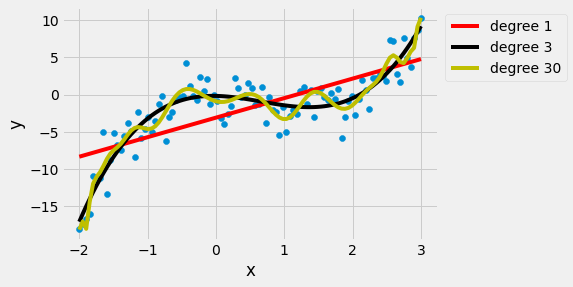

In [ ]:
fig,ax = plt.subplots()
ax.scatter(x_ex1,y_ex1)
ax.plot(x_ex1,model.predict(x_ex1.reshape(len(x_ex1),-1)),c='r',label='Grado 1')
ax.plot(x_ex1,model3.predict(x3),c='k',label='Grado 3')
ax.plot(x_ex1,model30.predict(x30),c='y',label='Grado 30')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend(loc='upper left', bbox_to_anchor=(1,1));

¿No sería genial si pudiéramos cambiar de alguna manera nuestra función de pérdida para desalentar el ajuste excesivo?

Ese es exactamente el objetivo de la **regresión regularizada**.

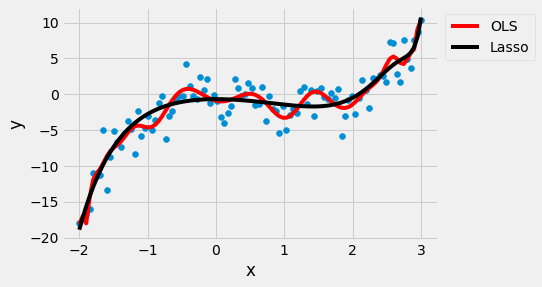

In [ ]:
# Construimos un modelo
model_lasso30 = Lasso(alpha=0.1)
model_lasso30.fit(x30, y_ex1);

fig,ax = plt.subplots()
ax.scatter(x_ex1,y_ex1)
ax.plot(x_ex1,model30.predict(x30),c='r',label='OLS')
ax.plot(x_ex1,model_lasso30.predict(x30),c='k',label='Lasso')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend(loc='upper left', bbox_to_anchor=(1,1));

## Combatir el ajuste excesivo (Overfitting): Introducción a la regresión de Ridge y Lasso
Ridge y Lasso Regression son herramientas para combatir el overfitting...

En los últimos días hemos hablado de la regresión lineal, en la que encontramos los coeficientes $\beta_0$, $\beta_1$, ..., $\beta_p$ para minimizar

$$RSS = \sum_{i=1}^n \left( y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij} \right) \right)^2$$

### Ridge Regression
En **Ridge Regression** encontramos los valores a minimizar

$$ \sum_{i=1}^n \left( y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij} \right) \right)^2 + \alpha \sum_ {j=1}^{p}\beta_j^2$$

Efectivamente, hemos penalizado los valores extremos de $\beta$ (tenga en cuenta que no estamos incluyendo $\beta_0$). El valor $\alpha$ es un hiperparámetro del modelo que especifica qué tan grande debe ser la penalización.

Nota: $\alpha \sum_{j=1}^{p} \beta_j^2$ a menudo se denomina **penalización de regularización L2**.

**Pregunta:** ¿Qué significa esto si $\alpha = 0$?

**Pregunta:** ¿Qué significa esto si $\alpha \to \infty$

**Pregunta:** ¿Cómo debemos decidir el valor apropiado para $\alpha$?


### Lasso Regression 

En **LASSO Regession** (**L**east **A**absolute **S**hrinkage y **S**election **O**perator) encontramos los valores a minimizar

$$ \sum_{i=1}^n \left( y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij} \right)\right)^2 + \alpha \sum_ {j=1}^{p} | \beta_j |$$

En muchos sentidos, esto es similar a Ridge:
   * Estamos penalizando valores grandes de $\beta$.
   * No estamos incluyendo $\beta_0$.
   * Tenemos un hiperparámetro $\alpha$.

La diferencia es el exponente. Ridge a veces se conoce como **regularización L2**, mientras que LASSO es **regularización L1**.


**Preguntas:**

1. ¿Cómo se relaciona esto con el compromiso entre sesgo y varianza? Si $\alpha$ aumenta, ¿qué sucede con el sesgo? ¿Qué sucede con la varianza?

## Visualizando la función de pérdida

### Ejemplo 1D

Para ilustrar esto, grafiquemos la función de pérdida para un modelo simple. Digamos que construimos un modelo donde solo necesitamos encontrar un hiperparámetro. Es decir, asumimos que la intersección con el eje y de una línea es 0 y necesitamos encontrar la pendiente, $\beta$. La forma funcional asumida será,

$$f(x)=\beta x$$.

Nuestra función de pérdida para OLS se convierte en,

$$RSS = \sum_{i=1}^n ( y_i - \beta x_{i} )^2$$

y la función de pérdida para Ridge y Lasso se convierte en,

Cresta:
$$ \text{Pérdida}_{\text{Ridge}}(\beta) = \alpha \beta^2 + \sum_{i=1}^n ( y_i - \beta x_{i} ) )^2 $ ps

Lazo:
$$ \text{Pérdida}_{\text{Lazo}}(\beta) = \alpha |\beta | + \sum_{i=1}^n ( y_i - \beta x_{i}) $$

Ok, dados los datos, algunos datos, tracemos nuestra función de pérdida. Tenga en cuenta que el RP a continuación se refiere a la sanción de regularización ($\alpha \beta^2$ o $\alpha |\beta |$ ) y RSS se refiere a la suma residual de cuadrados.

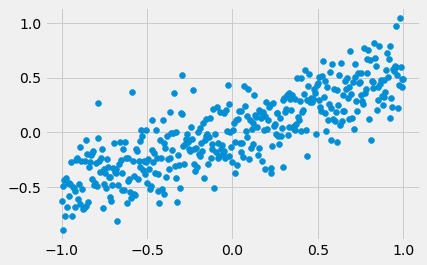

In [ ]:
# obtener datos con relación lineal más ruido
x = np.linspace(-1,1,400)
y = 0.5*x + 0.2*np.random.normal(size=len(x))

fig,ax = plt.subplots()
ax.scatter(x,y);

In [ ]:
# Funciones para trazar funciones de pérdida
def plot_rp(ax, alpha, loss='Ridge'):
    '''
    penalización de regularización de parcelas por ridge y lasso
    '''
    if loss == 'Ridge':
        ax.plot(b,alpha*np.power(b,2), c='r')
    else:
        ax.plot(b,alpha*np.abs(b), c='r')
    ax.set_xlabel("$\\beta$")
    ax.set_ylabel("Sanción de Regularización (RP))")
    ax.set_title("{} RP".format(loss))

def plot_rss(ax):
    '''
    Grafica la pérdida de RSS y la función de mínimos de pérdida
    
     devuelve el índice de mínimos para que este punto se pueda graficar en la función de pérdida de rigde y lasso
    '''
    loss_val = [np.dot(y - bs*x,y - bs*x) for bs in b] # obtener una matriz de valores de la función de pérdida
    ax.plot(b, loss_val, c='b')
    ax.scatter(b[np.argmin(loss_val)],np.amin(loss_val),c='b',s=100) # grafica mínimos de función de pérdida
    ax.set_xlabel("$\\beta$")
    ax.set_ylabel("OLS Loss Function")
    ax.set_title("RSS Loss")
    return np.argmin(loss_val)
     
def plot_ridge_lasso(ax, alpha, index=None, show_minima=True, loss='Ridge',color='k'):
    '''
    Grafica la pérdida de rigde/lasso frente a beta y los mínimos de la función de pérdida de rigde/lasso y OLS
    
     Parámetros
     ----------
     alfa: parámetro alfa para el intercambio de RP y RSS
     índice: índice para la matriz b que representa los mínimos de OLS; si Ninguno, este punto no se graficara
     show_minima: solo grafica los mínimos de la rigde/lasso si es verdadero
     pérdida: Ridge o Lasso
    '''
    if loss == 'Ridge':
        loss_val = [np.dot(y - bs*x,y - bs*x)+alpha*bs**2 for bs in b]
        ax.plot(b,loss_val, c=color, label='α={}'.format(alpha),zorder=1)
    else:
        loss_val = [np.dot(y - bs*x,y - bs*x)+alpha*np.absolute(bs) for bs in b]
        ax.plot(b,loss_val, c=color, label='α={}'.format(alpha),zorder=1)
    if index != None:  # plot OLS minima only if index given
        ax.scatter(b[index],loss_val[index],c='b',s=100,zorder=2,label='OLS solution')
    xmin,ymin = b[np.argmin(loss_val)],np.amin(loss_val)
    if show_minima:
        ax.scatter(xmin,ymin,c='k',s=100,label='Solución de regularización'.format(loss))
    ax.set_xlabel("$\\beta$")
    ax.set_ylabel("{}Función de perdida".format(loss))
    ax.set_title("{}".format(loss))

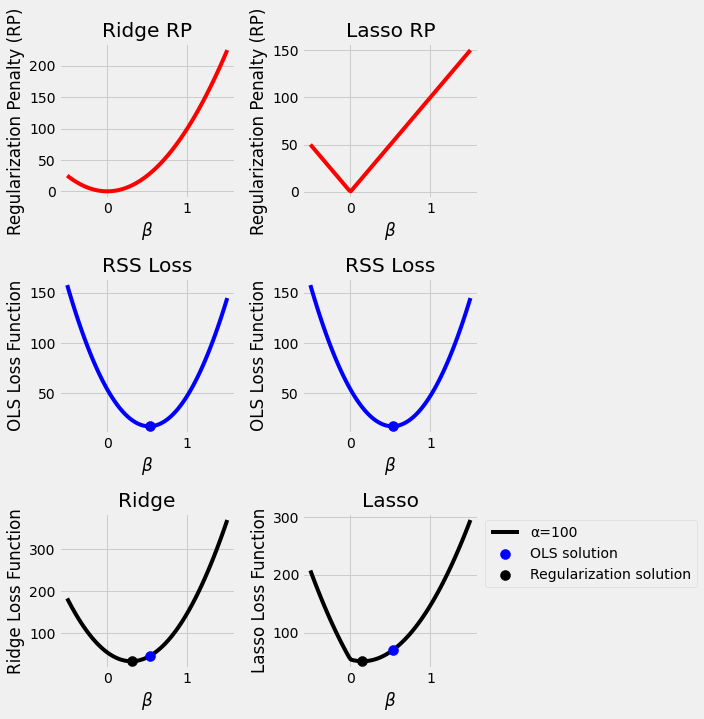

In [ ]:
# variables para graficar funciones de pérdida
alpha = 100
b = np.linspace(-0.5,1.5,100)

# graficar los componentes de las funciones de pérdida
fig,axs = plt.subplots(3,2,figsize=(10,10))
# plots for ridge loss
plot_rp(axs[0,0],alpha,loss='Ridge')
index = plot_rss(axs[1,0])
plot_ridge_lasso(axs[2,0], alpha, index=index, loss='Ridge')

# Gráfica de perdida de ridge
plot_rp(axs[0,1], alpha, loss='Lasso')
index = plot_rss(axs[1,1])
plot_ridge_lasso(axs[2,1], alpha, index=index, loss='Lasso')
axs[2,1].legend(loc='upper left',bbox_to_anchor=(1,1)) # leyenda de la gráfica solo para lasso

fig.tight_layout()

### Alfa variable

Primero, tomemos el ejemplo 1D de antes y varíemos visualmente el alfa para ver qué sucede.

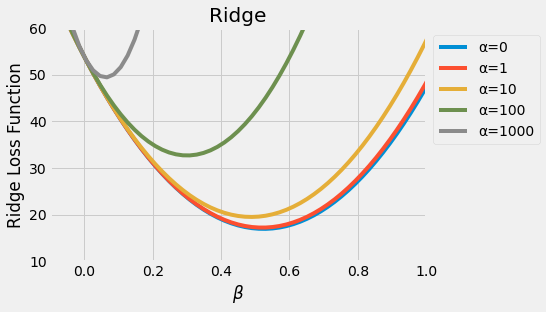

In [ ]:
alpha_array = [0,1,10,100,1000]
fig,ax = plt.subplots()
for i,alpha in enumerate(alpha_array):
    plot_ridge_lasso(ax, alpha, index=None,loss='Ridge',show_minima=False,color=None)  
ax.legend(loc='upper left',bbox_to_anchor=(1,1))
ax.set_xlim([-0.1,1.0])
ax.set_ylim([10,60]);

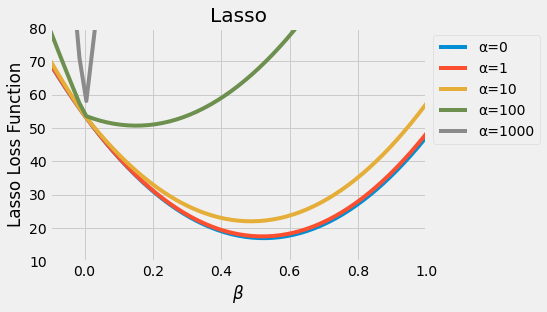

In [ ]:
alpha_array = [0,1,10,100,1000]
fig,ax = plt.subplots()
for i,alpha in enumerate(alpha_array):
    plot_ridge_lasso(ax, alpha, index=None,loss='Lasso',show_minima=False,color=None)  
ax.legend(loc='upper left',bbox_to_anchor=(1,1))
ax.set_xlim([-0.1,1.0])
ax.set_ylim([10,80]);

### ¿Cómo seleccionar alfa? Un ejemplo de alta dimensión

Ok, alfa empujará el coeficiente ideal hacia cero. Pero esto realmente no nos ayuda en el caso 1D donde solo necesitamos encontrar la pendiente de una línea.

Comencemos con el ejemplo del polinomio del comienzo de esta lección y veamos cómo alfa afecta nuestros coeficientes. Comenzaremos trazando nuestro modelo OLS sobreajustado como recordatorio:

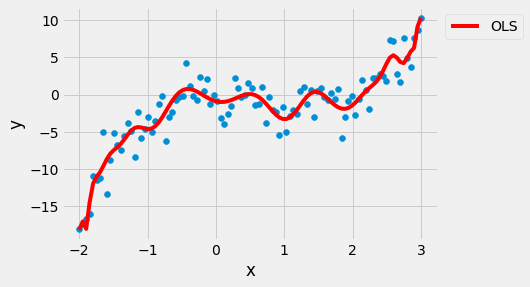

In [ ]:
fig,ax = plt.subplots()
ax.scatter(x_ex1,y_ex1)
ax.plot(x_ex1,model30.predict(x30),c='r',label='OLS')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend(loc='upper left', bbox_to_anchor=(1,1));

A continuación, construyamos varios modelos de Lasso donde consideramos múltiples valores de $\alpha$. Luego compararemos tanto el puntaje de estos modelos en los datos de prueba a través de RMSE como también cómo varía el coeficiente beta para varias características.

**Pregunta**

1. Para comparar directamente la magnitud de nuestros coeficientes beta, ¿qué debemos hacer con nuestros datos?
2. ¿Por qué más sería esto importante?

In [ ]:
# Aviso normalizar bandera -- esto automáticamente estandarizará nuestros datos para nosotros
model_lasso30 = Lasso(alpha=0.1)  
model_lasso30.fit(x30, y_ex1);

In [ ]:
def get_ridge_lasso_coeff(x,y,min_alpha_exp, max_alpha_exp, reg='Lasso',cv=True):
      '''
     construye múltiples modelos de cresta o lazo para 50 valores de alfa entre
     10^(min_alpha_exp) a 10^(max_alpha_exp)
    
     Devuelve una matriz de alfas y el coeficiente correspondiente para cada característica
     '''
    nalphas = 50
    nfeatures = len(x[0])
    coefs = np.zeros((nalphas, nfeatures))
    scores = np.zeros(nalphas)
    alphas = np.logspace(min_alpha_exp, max_alpha_exp, nalphas)
    x = StandardScaler().fit_transform(x)
    for i, alpha in enumerate(alphas):
        if reg == 'Lasso':
            model = Lasso(alpha=alpha,max_iter=2000000)
        else:
            model = Ridge(alpha=alpha,max_iter=20000)
        model.fit(x, y)
        if cv:
            scores[i] = (np.sqrt(-1*
                         cross_val_score(model, x, y, 
                                        scoring= 'neg_mean_squared_error',
                                        cv=5))).mean()
        else:
            # Toma en cuenta que los datos de prueba utilizados para la puntuación son específicos de los datos del polinomio de grado 30
            scores[i] =np.sqrt(np.sum((model.predict(x30_test) - y_ex1_test)**2)) #model.score(x30_test,y_ex1_test)
        coefs[i] = model.coef_
    return alphas, coefs, scores

In [ ]:
def plot_alpha_v_coef(ax, alphas, coefs, column_names, method='Lasso'):
    '''
    grafica alfa contra los coeficientes beta 
    '''
    for feature in range(len(coefs[0])):
        if np.absolute(coefs[0,feature]) > 0.05 or feature == 2:  # Grafica coeficientes grandes + 3 orden
            ax.plot(alphas, coefs[:, feature],
                     label="$\\beta_{{{}}}$".format(column_names[feature]))  #'{} order'.format(feature+1))
    ax.set_xscale('log')
    ax.set_title("$\\beta$ as a function of $\\alpha$ for {} regression".format(method))
    ax.set_xlabel("$\\alpha$")
    ax.set_ylabel("$\\beta$")
    ax.legend(loc="upper left",bbox_to_anchor=(1,1))

def plot_alpha_v_scores(ax, alphas, scores):
    '''
    Diagramas alfa contra el RMSE
    '''
    ax.plot(alphas,scores,c='k')
    ax.scatter(alphas[np.argmin(scores)],scores.min(), c='k', s=100)
    print('El mejor RMSE es {}'.format( scores.min() ))
    ax.set_title('Puntuación del modelo en función de $\\alpha$')
    ax.set_xscale('log')
    ax.set_xlabel("$\\alpha$")
    ax.set_ylabel('RMSE');    #'$R^{2}$');

The best RMSE is 33.47419023051771


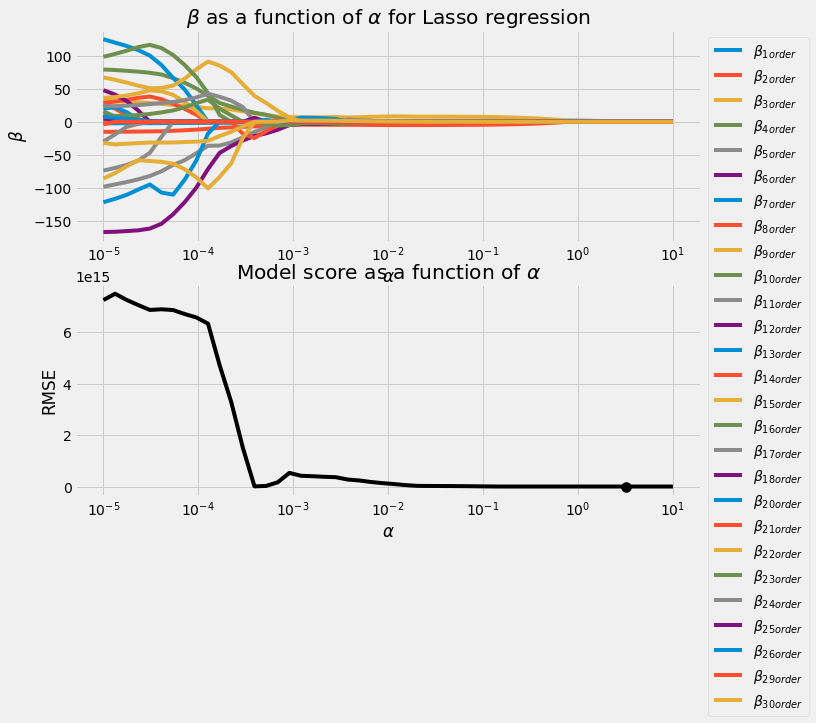

In [ ]:
# crear nombres de columna
column_names = ['{} order'.format(i)  for i in range(1,31) ]

# construir modelos para varios valores de alfa 
alphas, coefs, scores = get_ridge_lasso_coeff(x30,y_ex1,-5,1 ,reg='Lasso',cv=False)

# Gráficar datos 
fig, ax = plt.subplots(2,1,figsize=(10,8))
plot_alpha_v_coef(ax[0], alphas, coefs, column_names, method='Lasso')
plot_alpha_v_scores(ax[1], alphas, scores)
fig.tight_layout()

The best RMSE is 24326909868.624767


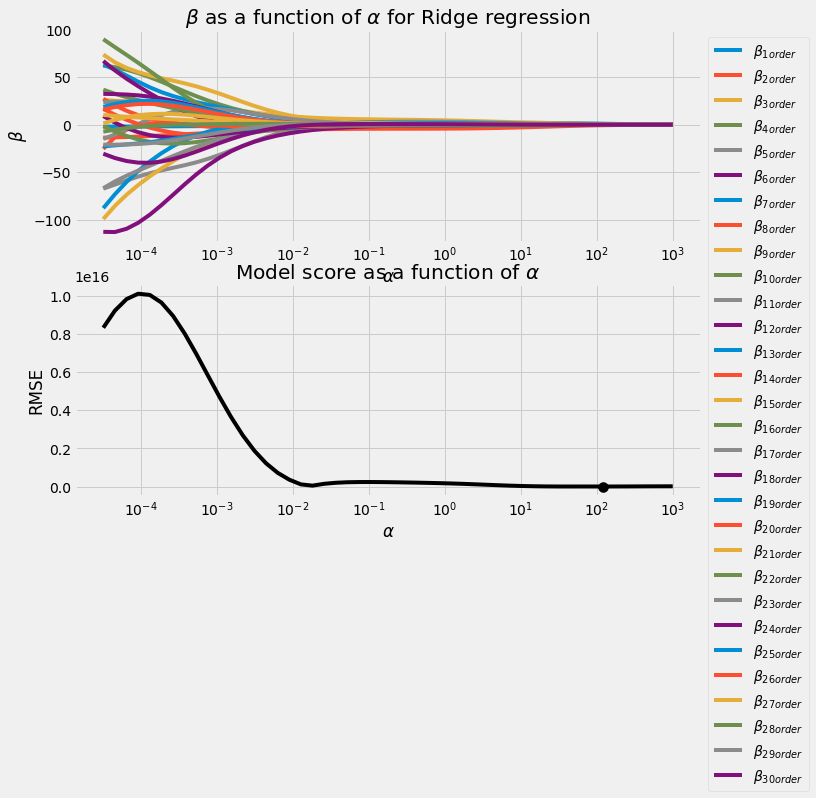

In [ ]:
alphas, coefs, scores = get_ridge_lasso_coeff(x30,y_ex1,-4.5,3, reg='Ridge',cv=False)
fig, ax = plt.subplots(2,1,figsize=(10,8))
plot_alpha_v_coef(ax[0], alphas, coefs, column_names, method='Ridge')
plot_alpha_v_scores(ax[1], alphas, scores)
fig.tight_layout()

**Discusión:** ¿Qué está pasando?

<br><br><br><br><br><br><br><br>

Arriba estoy trazando los coeficientes $\beta$ para múltiples grados de un polinomio de 30 grados. Estoy trazando los coeficientes que eran mayores que 0,01 en el valor más pequeño de $\alpha$.

Aquí notamos que a medida que $\alpha$ aumenta, todos los coeficientes van a cero. Curiosamente, los coeficientes no llegan a cero al mismo ritmo. En el caso de Lasso, los datos polinómicos de segundo y tercer orden son los más importantes para ajustar estos datos. Esto encaja perfectamente con la forma funcional del polinomio que se usó para crear los datos: $f(x)= x^3 -2 x^2 +ruido$. En el caso de ridge, utiliza más características para ajustarse a su modelo ideal, que es una característica de la regresión de ridge.

Por último, veamos cómo funcionan los modelos en varios valores de $\alpha$.

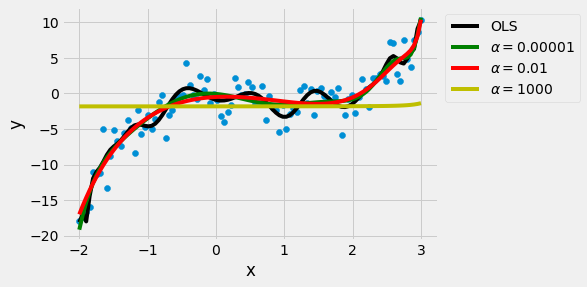

In [ ]:
# adaptarse a tres modelos con
model_alpha_0001 = Ridge(alpha=0.00001,  normalize=True).fit(x30, y_ex1)  
model_alpha_01 = Ridge(alpha=0.01,  normalize=True).fit(x30, y_ex1) 
model_alpha_1000 = Ridge(alpha=1000,  normalize=True).fit(x30, y_ex1)  


fig,ax = plt.subplots()
ax.scatter(x_ex1,y_ex1)
ax.plot(x_ex1,model30.predict(x30),label='OLS',c='k')
ax.plot(x_ex1,model_alpha_0001.predict(x30),label='$\\alpha=0.00001$',c='g')
ax.plot(x_ex1,model_alpha_01.predict(x30),label='$\\alpha=0.01$',c='r')
ax.plot(x_ex1,model_alpha_1000.predict(x30),label='$\\alpha=1000$',c='y')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend(loc='upper left', bbox_to_anchor=(1,1));

## Un ejemplo realista: conjunto de datos de automóviles

Esta vez, usemos datos más realistas, el conjunto de datos de automóviles, para investigar el hiperparámetro $\alpha$ y ver qué información podemos obtener. En este ejemplo, intentaremos predecir el mpg a partir de las otras funciones.

Tenga en cuenta que omitiré EDA aquí solo porque hemos hecho EDA anteriormente con este conjunto de datos en el cuaderno EDA (conferencia de pandas). **Nunca te saltes EDA**.


In [ ]:
cars = pd.read_csv('cars.csv')

In [ ]:
# Desechar algunos datos incorrectos. No hagas esto en casa.
cars = cars[cars.horsepower != '?']
cars.horsepower = cars.horsepower.astype('float64')

In [ ]:
columns = ['cilindros', 'desplazamiento', 'caballos de fuerza', 'peso', 'aceleración', 'modelo']
X = cars[columns].copy()
y = cars['mpg'].to_numpy()
X.head()

,cylinders,displacement,horsepower,weight,acceleration,model
0,8,307.0,130.0,3504.0,12.0,70
1,8,350.0,165.0,3693.0,11.5,70
2,8,318.0,150.0,3436.0,11.0,70
3,8,304.0,150.0,3433.0,12.0,70
4,8,302.0,140.0,3449.0,10.5,70


In [ ]:
# test train split! (División de datos train/test)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30)
# Estandarización de los datos
ss = StandardScaler()
ss.fit(X_train)  # esto solo calcula la media y la varianza de los datos
X_train_s = ss.transform(X_train)
X_test_s = ss.transform(X_test)

#ss2 = StandardScaler()
#ss2.fit(y_train.reshape(((len(y_train),-1))))  # this just calculates mean and variance of data 
#y_train_s = ss2.transform(y_train.reshape((len(y_train),-1)))
#y_test_s = ss2.transform(y_test.reshape((len(y_test),-1)))

#### Lasso 
Podemos ver cómo los coeficientes dependen de varios valores de $\alpha$.]

The best RMSE is 3.2056054540366765


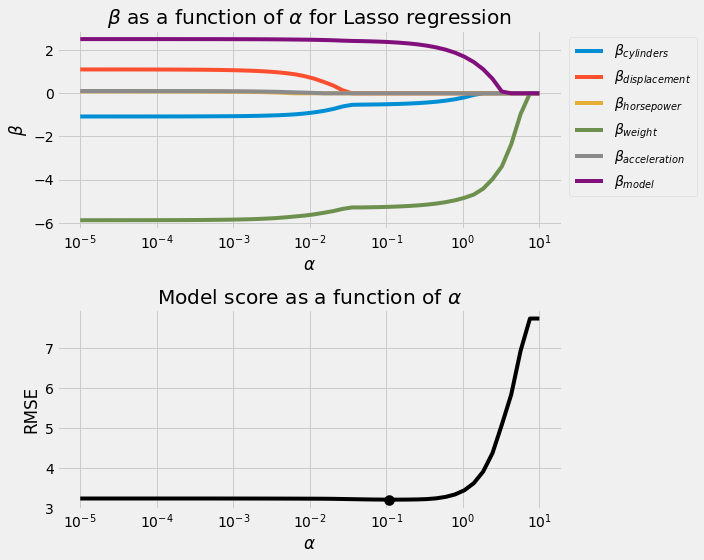

In [ ]:
alphas, coefs, scores = get_ridge_lasso_coeff(X_train_s, y_train, -5, 1, reg='Lasso')
fig, ax = plt.subplots(2,1,figsize=(10,8))
plot_alpha_v_coef(ax[0], alphas, coefs, columns, method='Lasso')
plot_alpha_v_scores(ax[1], alphas, scores)
fig.tight_layout()

#### Ridge

The best RMSE is 3.2315292976960857


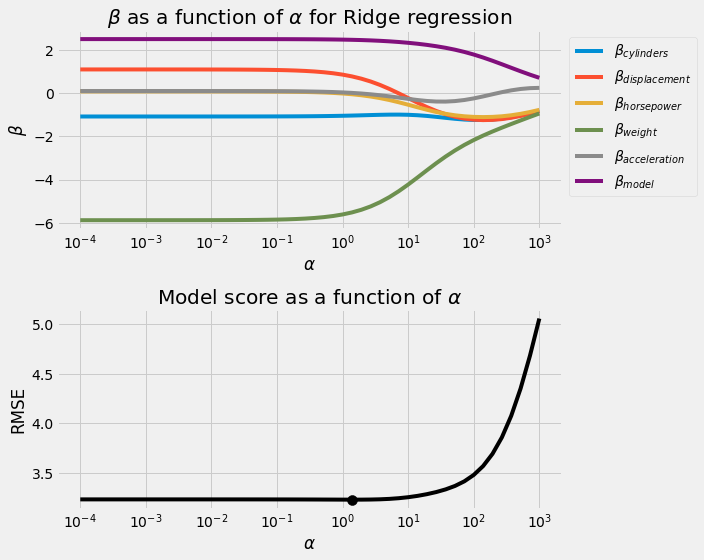

In [ ]:
alphas, coefs, scores = get_ridge_lasso_coeff(X_train_s, y_train, -4, 3, reg='Ridge')
fig, ax = plt.subplots(2,1,figsize=(10,8))
plot_alpha_v_coef(ax[0], alphas, coefs, columns, method='Ridge')
plot_alpha_v_scores(ax[1], alphas, scores)
fig.tight_layout()

Discusión: ¿qué está pasando? ¿En qué se diferencia esto de LASSO?

<br><br><br><br>

### Comparación de la regresión Ridge contra Lasso

Una de las mayores diferencias entre la regresión de cresta y lazo es que la regresión de cresta solo puede reducir los coeficientes $\beta$ asintóticamente a 0, mientras que Lasso puede reducir los coeficientes $\beta$ a 0.

Las consecuencias de esto son que Ridge es un buen modelo para seleccionar cuando todas las variables son algo útiles, mientras que Lasso es bueno y elimina variables inútiles.

**Ridge**
- computacionalmente más fácil porque la penalización de regularización es diferenciable
- tiende a usar varias características y coeficientes de fuerza para ser más pequeños
- $\beta$ se acerca asintóticamente a 0

**Lasso**
- computacionalmente más difícil porque la sanción de regularización no es diferenciable
- bueno para eliminar funciones inútiles, actuando como un selector automático de funciones

Evitaría el uso predeterminado de la regularización para la selección de características. Usar el conocimiento del dominio para la selección de funciones es casi siempre la mejor ruta. Ajuste su modelo con regularización después de ese punto.

## Contenido opcional


### Red elástica
¡La red elástica combina el lazo y la cresta en un solo método con dos hiperparámetros para que pueda obtener los beneficios de ambos métodos!

$$ \sum_{i=1}^n \left( y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij} \right) \right)^2 + \alpha_{1 } \sum_{j=1}^{p} \beta_j^2 + \alpha_{2} \sum_{j=1}^{p} | \beta_j |$$



### Visualización de funciones de pérdida en dimensiones superiores
Para ayudar a comprender esto, considere los gráficos de contorno de las funciones de pérdida para el RSS y para el término de penalización de regularización. Imagina que el centro de cada uno es el mínimo y estamos buscando el mínimo de la suma.

In [ ]:
def draw_circle(ax, radius, color, x=0, y=0):
    artist = plt.Circle((x, y),
                             radius,
                             color=color,
                             fill=False)
    ax.add_artist(artist)
    return artist
def draw_diamond(ax, radius, color, x=0, y=0):
    artist = plt.Polygon([(x, radius+y),
                               (radius+x, y),
                               (x, -radius+y),
                               (-radius+x, y)],
                              color=color,
                              fill=False)
    ax.add_artist(artist)
    return artist

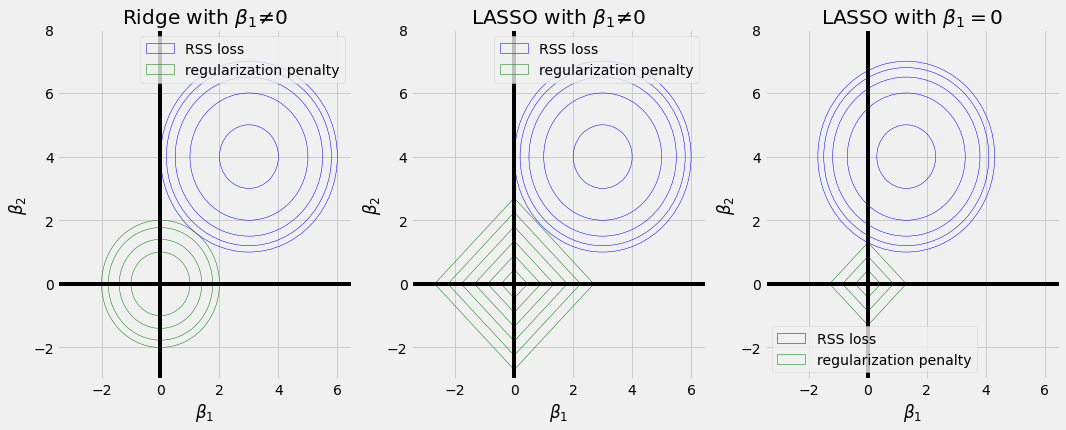

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
for ax in axs:
    ax.axhline(0, color='k')
    ax.axvline(0, color='k')
    ax.set_xlabel(r"$\beta_1$")
    ax.set_ylabel(r"$\beta_2$")

axs[0].set_title(r"Ridge con $\beta_1 \ne 0$")
for r in [1.0, 2.0, 2.5, 2.8, 3.0]:
    artist_loss = draw_circle(axs[0], r, 'b', 3, 4)
for r in [1.0, 1.4, 1.77, 2.0]:
    artist_regularization = draw_circle(axs[0], r, 'g')
axs[0].legend([artist_loss, artist_regularization], ['Perdida RSS', 'sanción de regularización'])

axs[1].set_title(r"LASSO with $\beta_1 \ne 0$")
for r in [1.0, 2.0, 2.5, 2.8, 3.0]:
    artist_loss = draw_circle(axs[1], r, 'b', 3, 4)
for r in [0.45, 0.9, 1.35, 1.8, 2.25, 2.7]:
    artist_regularization = draw_diamond(axs[1], r, 'g')
axs[1].legend([artist_loss, artist_regularization], ['Perdida RSS', 'sanción de regularización'])

# Example with LASSO at zero
axs[2].set_title(r"LASSO with $\beta_1 = 0$")
for r in [1.0, 2.0, 2.5, 2.8, 3.0]:
    artist_loss = draw_circle(axs[2], r, 'b', 1.3, 4)
for r in [0.433, 0.866, 1.3]:
    artist_regularization = draw_diamond(axs[2], r, 'g')
axs[2].legend([artist_loss, artist_regularization], ['Perdida RSS', 'sanción de regularización'])

for ax in axs:
    ax.set_xlim(-3.5, 6.5)
    ax.set_ylim(-3, 8)

El mínimo de una suma de funciones ocurre cuando el gradiente de la suma de las funciones es cero. Esto ocurre cuando los gradientes de las dos funciones son iguales y opuestos, lo que ocurre cuando las curvas de nivel son paralelas.

En las gráficas anteriores, imagine que las soluciones mínimas están en los puntos cuando las líneas de contorno exteriores son tangentes. Para la regresión de Ridge, un mínimo en $\beta_i = 0$ es muy poco probable, pero bastante posible para la regresión LASSO.

### Estandarización de datos

Es importante estandarizar sus datos al usar Lasso o Ridge Regression.

**Pregunta** ¿Por qué?

**Revisar:**

**Estandarización** (en este contexto) es el proceso de restar la media de cada función y luego dividirla por la desviación estándar, por lo que cada función tiene una media de 0 y una desviación estándar de 1.

En regresión lineal sin regularización, la escala **no importa**. Si cambia la escala de una característica (multiplicando cada valor por una constante), cambiará el coeficiente correspondiente **pero las predicciones serán exactamente las mismas**.

Esto no es cierto cuando agregamos la regularización. Dado que incluimos un término que es proporcional a $\beta$, las predicciones reales cambiarán si cambiamos la escala de los valores.

Como regla general, si cambiar las unidades de las características cambiará las predicciones de un modelo, debe estandarizar (o normalizar) los valores.

Estandaricemos los datos con `sklearn`.

In [ ]:
from sklearn.preprocessing import StandardScaler

X_demo = np.array( [[5,10],
                    [-5,2]] )

# Estandarización de la forma "hard coded"
print( (X_demo - np.mean(X_demo, axis=0, keepdims=True) ) /  np.std(X_demo, axis=0, keepdims=True))
# Estandarización con Sklearn
print( StandardScaler().fit_transform(X_demo) )

[[ 1.  1.]
 [-1. -1.]]
[[ 1.  1.]
 [-1. -1.]]


Tenga en cuenta que sklearn tiene tres métodos que hacen cosas similares...

- `fit`: calcula los valores necesarios para transformar sus datos (media y desviación estándar) y almacena los valores como atributos
- `transformar`: estandarizó sus datos en función de los valores calculados en ajuste
- `fit_transform`: realiza tanto un ajuste como una transformación en el mismo conjunto de datos.

**Pregunta**

1. ¿Por qué tenemos prácticamente estos tres métodos diferentes?